<a href="https://colab.research.google.com/github/m677s345/EECS_731_MS_Project_3/blob/master/EECS_731_MS_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science


     |████████████████████████████████| 51kB 1.5MB/s 
project_name [project_name]: EECS_731_MS_Project_3
repo_name [eecs_731_ms_project_3]: EECS_731_MS_Project_3
author_name [Your name (or your organization/company/team)]: Matt Stalcup
description [A short description of the project.]: 
Select open_source_license:
1 - MIT
2 - BSD-3-Clause
3 - No license file
Choose from 1, 2, 3 [1]: 
s3_bucket [[OPTIONAL] your-bucket-for-syncing-data (do not include 's3://')]: 
aws_profile [default]: 
Select python_interpreter:
1 - python3
2 - python
Choose from 1, 2 [1]: 


# Packages

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn import metrics
from scipy.spatial.distance import cdist

# Data Exploration

In [4]:
from zipfile import ZipFile 
# specifying the zip file name 
file_name = "/content/EECS_731_MS_Project_3/data/raw/ml-latest-small.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall('/content/EECS_731_MS_Project_3/data/interim') 
    print('Done!') 


File Name                                             Modified             Size
ml-latest-small/                               2018-09-26 15:50:12            0
ml-latest-small/links.csv                      2018-09-26 15:50:10       197979
ml-latest-small/tags.csv                       2018-09-26 15:49:40       118660
ml-latest-small/ratings.csv                    2018-09-26 15:49:38      2483723
ml-latest-small/README.txt                     2018-09-26 15:50:12         8342
ml-latest-small/movies.csv                     2018-09-26 15:49:56       494431
Extracting all the files now...
Done!


In [64]:


movie_data=pd.read_csv('/content/EECS_731_MS_Project_3/data/interim/ml-latest-small/movies.csv', header=0 )
rating_data=pd.read_csv('/content/EECS_731_MS_Project_3/data/interim/ml-latest-small/ratings.csv', header=0 )
tag_data=pd.read_csv('/content/EECS_731_MS_Project_3/data/interim/ml-latest-small/tags.csv', header=0 )
links_data=pd.read_csv('/content/EECS_731_MS_Project_3/data/interim/ml-latest-small/links.csv', header=0 )
display(movie_data.head(5))
display(rating_data.head(5))
display(tag_data.head(5))
display(links_data.head(5))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In the movie data dataset the genras are going to be difficult to read so we are going to need to split them into different features

In [65]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
split_generas=movie_data.genres.str.split('|', expand=True) #splits the string based on |
#below creates the genra columns by removing axis labels and returning DF values then flattening the array and dropping na
genre_columns=np.unique(pd.DataFrame(pd.DataFrame(split_generas.to_numpy()).to_numpy().flatten()).dropna().to_numpy().ravel())
genre_columns=np.sort(genre_columns)[::-1]
for genras in genre_columns:
    movie_data.insert(2, genras,  [int(genras in i) for i in movie_data.genres.str.split('|', expand=False)], True)
del movie_data['genres']


In [7]:
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Visualization of binary correlations to determine what pairs of movie tags are similar and different 

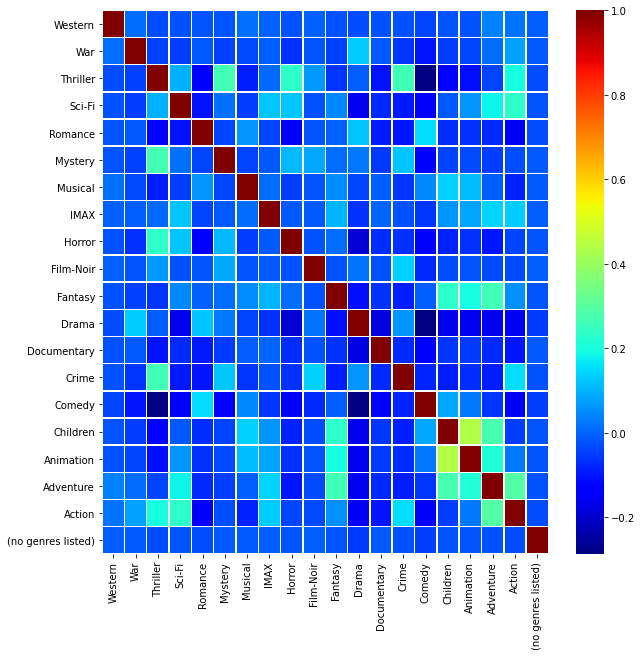

In [66]:
plt.figure(figsize=(10,10))
sns.heatmap(movie_data[genre_columns].corr(),cmap="jet",linewidths=.5)


Most of these results make sense children and animation have a strong correlation where comedy and thriller are not correlated at all. 

# Feature Engineering

In [67]:
#functions for getting the average movie rating and the number of ratings of a movie
def getAverageRating(movie_id):                                                 
    return rating_data.loc[rating_data['movieId'] == movie_id]['rating'].mean()
def getRatingCount(movie_id):
    return rating_data.loc[rating_data['movieId'] == movie_id]['rating'].count()
#actual movie ratings and number of ratings getting stores as variables 
average_ratings = movie_data['movieId'].map(lambda x: getAverageRating(x))
rating_count = movie_data['movieId'].map(lambda x: getRatingCount(x))
movie_data['Rating'] = average_ratings
movie_data['Num_of_Ratings'] = rating_count

In [13]:
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.920930,215
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.431818,110
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.259615,52
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.357143,7
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.071429,49


In [68]:
movie_data.sort_values(by=['Rating', 'Num_of_Ratings'],ascending=False,inplace=True)
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
48,53,Lamerica (1994),0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5.0,2
87,99,Heidi Fleiss: Hollywood Madam (1995),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5.0,2
870,1151,Lesson Faust (1994),0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5.0,2
2597,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,2
4390,6442,Belle époque (1992),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.0,2


This worked like expected we see the highest rated movies; however, they were only rated by 2 people. As far as the usefulness of this sorting isn't very high. We can use clustering models to assign a weight to relate the average rating to the number of ratings giving us a more useful way to sort the data. I used a Baysean Average to assign weights to the reviews

In [69]:
#creating variables to be used in the calculation of the variable weights 
movie_data['rating_weight']=movie_data['Num_of_Ratings']/(movie_data['Num_of_Ratings']+movie_data['Rating'])
C = np.nanmean(movie_data['Rating'].values.flatten())
#calculation of Baysean weight for the rating system 
movie_data['my_score']=movie_data['rating_weight']*movie_data['Rating']+(1-movie_data['rating_weight'])*C

In [70]:
movie_data.sort_values(by=['my_score'],ascending=False,inplace=True)
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,rating_weight,my_score
277,318,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.429022,317,0.986221,4.412948
659,858,"Godfather, The (1972)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.289062,192,0.978149,4.266630
2226,2959,Fight Club (1999),0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4.272936,218,0.980776,4.253510
841,1104,"Streetcar Named Desire, A (1951)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.475000,20,0.817160,4.253297
922,1221,"Godfather: Part II, The (1974)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.259690,129,0.968035,4.227813


We see now that we can sort the dataset and get critically acclaimed movies like Shawshank redemption and The Godfather as the top movies where they also have a lot of reviews. 

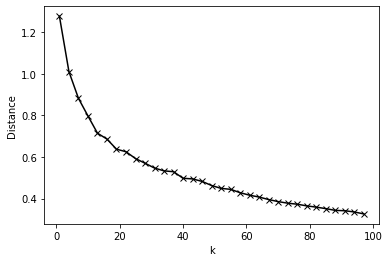

In [71]:
movie_data.dropna(inplace=True)
clusterfeatures=movie_data.drop(columns=['Num_of_Ratings', 'Rating', 'title', 'movieId','my_score', 'rating_weight'])
distances=[]
#created a range of K's to determine the elbow and number of clusters
K=range(1,100,3)
for k in K:
  kmeanmodel=KMeans(n_clusters=k).fit(clusterfeatures)
  kmeanmodel.fit(clusterfeatures)
  distances.append(sum(np.min(cdist(clusterfeatures,kmeanmodel.cluster_centers_,'euclidean'),axis=1))/clusterfeatures.shape[0])

plt.plot(K,distances,'kx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.show()

The above graph shows how the distace between points changes with the number of clusters. We can see that the elbow in the curve occours at the 17ish mark and so thats the number of clusters I picked 

In [72]:
kmeans=KMeans(n_clusters=17).fit_predict(clusterfeatures)
movie_data['Cluster']=kmeans
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,rating_weight,my_score,Cluster
277,318,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.429022,317,0.986221,4.412948,8
659,858,"Godfather, The (1972)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.289062,192,0.978149,4.266630,8
2226,2959,Fight Club (1999),0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4.272936,218,0.980776,4.253510,8
841,1104,"Streetcar Named Desire, A (1951)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.475000,20,0.817160,4.253297,1
922,1221,"Godfather: Part II, The (1974)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.259690,129,0.968035,4.227813,8


Here I used K means and defigned the number of clusters from the cluster features to determine what cluster a movie belonged in. I save that information in a seperate column in the dataset so I can easilly see what other titles belong in the same cluster. 

In [73]:
movie_data.sort_values(by=['my_score','Cluster'],ascending=False,inplace=True)
movie_data.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,rating_weight,my_score,Cluster
277,318,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.429022,317,0.986221,4.412948,8
659,858,"Godfather, The (1972)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.289062,192,0.978149,4.266630,8
2226,2959,Fight Club (1999),0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4.272936,218,0.980776,4.253510,8
841,1104,"Streetcar Named Desire, A (1951)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.475000,20,0.817160,4.253297,1
922,1221,"Godfather: Part II, The (1974)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.259690,129,0.968035,4.227813,8


# Clustering Algorithms

Next we use the movie and the cluster information from a movie to find the 10 best rated movies from the same cluster.

In [75]:
def findSimilarMovie(movieTitle):
    cluster=movie_data.loc[movie_data['title']==movieTitle]['Cluster'].values[0]
    cluster_movies=movie_data.loc[movie_data['Cluster']==cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(10)
findSimilarMovie('Up (2009)')


,0
0,Toy Story 3 (2010)
1,WALL·E (2008)
2,"Grand Day Out with Wallace and Gromit, A (1989)"
3,Wallace & Gromit: The Wrong Trousers (1993)
4,Wallace & Gromit: The Best of Aardman Animatio...
5,Up (2009)
6,"Iron Giant, The (1999)"
7,FLCL (2000)
8,Finding Nemo (2003)
9,Fantastic Mr. Fox (2009)


In [55]:
findSimilarMovie('Godfather: Part II, The (1974)')

,0
0,"Shawshank Redemption, The (1994)"
1,"Godfather, The (1972)"
2,"Streetcar Named Desire, A (1951)"
3,"Godfather: Part II, The (1974)"
4,Goodfellas (1990)
5,Lawrence of Arabia (1962)
6,Schindler's List (1993)
7,Cool Hand Luke (1967)
8,Secrets & Lies (1996)
9,"Three Billboards Outside Ebbing, Missouri (2017)"


In [57]:
findSimilarMovie('Men in Black (a.k.a. MIB) (1997)')

,0
0,"Matrix, The (1999)"
1,Logan (2017)
2,Blade Runner (1982)
3,"Road Warrior, The (Mad Max 2) (1981)"
4,Terminator 2: Judgment Day (1991)
5,Edge of Tomorrow (2014)
6,"Thing, The (1982)"
7,"Terminator, The (1984)"
8,Limitless (2011)
9,V for Vendetta (2006)


Overall the Kmeans make fairly good predictions for movies based on the mentioned movie. A animated adventure movie like Up has other animated movies recommended. The Godfather is more related to other crittically acclaimed movies but still has good suggestions and MIB fit really well with a lot of sci-fi movies. The downfall of this method will be when you try to sort along very specific lines. 17 centroids are good enough to find rough types of movies but will not be able to find subtypes of those genras. 

Next we will us the AgglomerativeClustering found in Sci-kit learn. It works by recursively merging pairs of clusters that minimally increases a given linkage distance outputtign a movie suggestion based on the most related movies. 

In [52]:
from sklearn.cluster import AgglomerativeClustering
df_ac=movie_data.sort_values(by=['my_score'], ascending=False)
clusterFactors2=df_ac.drop(columns=['Num_of_Ratings', 'Rating', 'title', 'movieId','my_score', 'rating_weight'])
agglomerative_clustering=AgglomerativeClustering(n_clusters=20).fit_predict(clusterFactors2)
df_ac['AgglomerativeClustering']=agglomerative_clustering
df_ac.sort_values(by=['AgglomerativeClustering', 'my_score'], inplace=True, ascending=False)


In [53]:
def findSimilarMovieAC(movieTitle):
    cluster=df_ac.loc[df_ac['title']==movieTitle]['AgglomerativeClustering'].values[0]
    cluster_movies=df_ac.loc[df_ac['AgglomerativeClustering'] == cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(10)

In [59]:
findSimilarMovieAC('Up (2009)')

,0
0,Spirited Away (Sen to Chihiro no kamikakushi) ...
1,Toy Story 3 (2010)
2,WALL·E (2008)
3,Howl's Moving Castle (Hauru no ugoku shiro) (2...
4,"Grand Day Out with Wallace and Gromit, A (1989)"
5,Wallace & Gromit: The Wrong Trousers (1993)
6,Wallace & Gromit: The Best of Aardman Animatio...
7,Up (2009)
8,"Iron Giant, The (1999)"
9,FLCL (2000)


In [ ]:
findSimilarMovieAC('Godfather: Part II, The (1974)')

,0
0,"Shawshank Redemption, The (1994)"
1,"Godfather, The (1972)"
2,"Streetcar Named Desire, A (1951)"
3,"Godfather: Part II, The (1974)"
4,Goodfellas (1990)
5,Lawrence of Arabia (1962)
6,Cool Hand Luke (1967)
7,Secrets & Lies (1996)
8,"Three Billboards Outside Ebbing, Missouri (2017)"
9,American History X (1998)


In [ ]:
findSimilarMovieAC('Men in Black (a.k.a. MIB) (1997)')

,0
0,"Matrix, The (1999)"
1,Logan (2017)
2,Blade Runner (1982)
3,"Road Warrior, The (Mad Max 2) (1981)"
4,Terminator 2: Judgment Day (1991)
5,Edge of Tomorrow (2014)
6,"Thing, The (1982)"
7,"Terminator, The (1984)"
8,Limitless (2011)
9,V for Vendetta (2006)


The outputs of both methods are logical movie suggestions, there are some slight differences in the animated movies and the drama movies;however, the sci-fi movie (MIB) was exavtly the same in the two methods. The next step is to test the same code on the full dataset, however I am not sure that the resources will be able to handle this.